## **What is pmdarima library used for?**
Pmdarima is a Python library used for time series forecasting and analysis. It provides automated ARIMA (AutoRegressive Integrated Moving Average) modeling capabilities, similar to R's auto.arima function. Key features include:
> Automatic selection of optimal ARIMA parameters
> Seasonal and non-seasonal ARIMA modeling

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
display(df)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## **Plot Data using matplotlib**

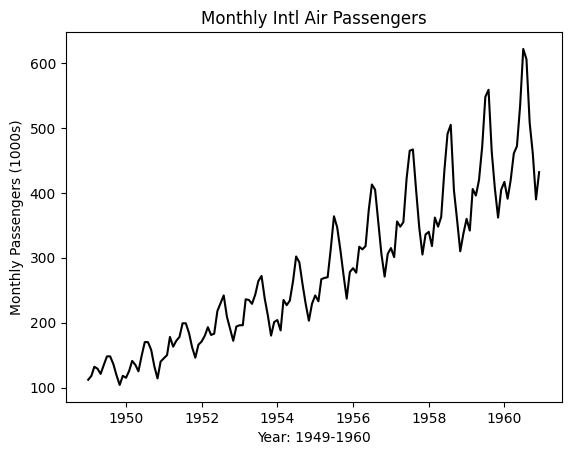

In [4]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### **Splitting the Dataset for Training and Testing:**

- Our goal is to predict future values in the time series.
- To do this, we'll use data from 1949 through 1957 for training the model.
- We'll then use data from 1958 through 1960 for testing the predictions.

In [5]:
trn = df.loc[df.index < '1958-01-01']

In [6]:
display(trn)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1957-08-01,467
1957-09-01,404
1957-10-01,347


**Plot the Training Data:**

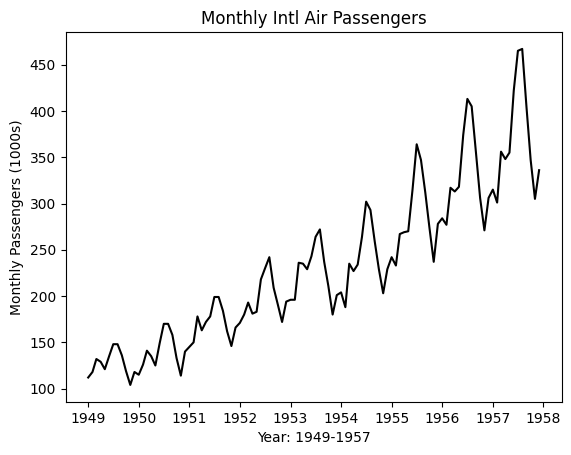

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### *Creating Testing data:*

In [8]:
tst = df.loc[df.index >= '1958-01-01']

- Plot the testing data.
- Note that the vertical scale changes from the previous graph.

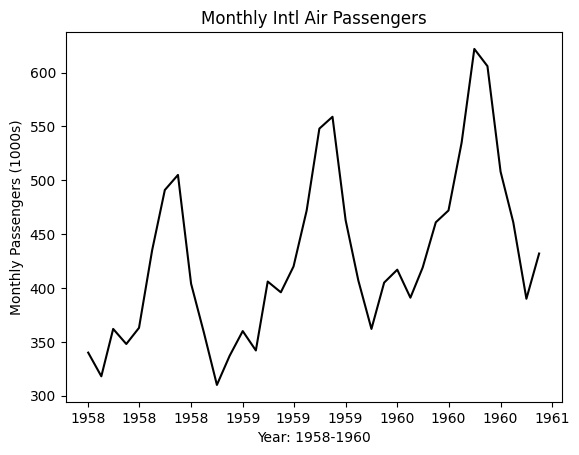

In [9]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## **Build the ML model:**

### *Test Stationarity:*

ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

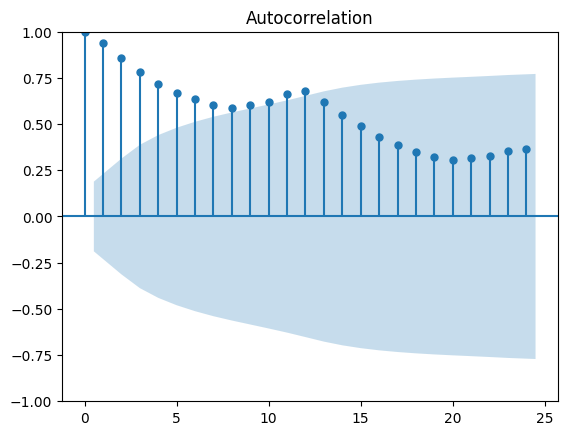

In [10]:
trn_acf = plot_acf(trn, lags=24)

### **Linear Model:**

- Fit a linear regression model to serve as a baseline. 
- The dependent (or endogenous) variable is the number of passengers. 
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [11]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           6.40e-43
Time:                        00:24:54   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [12]:
y_hat = lr.fittedvalues

In [13]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

**Graph time series with linear regression line and corresponding 95% prediction interval:**

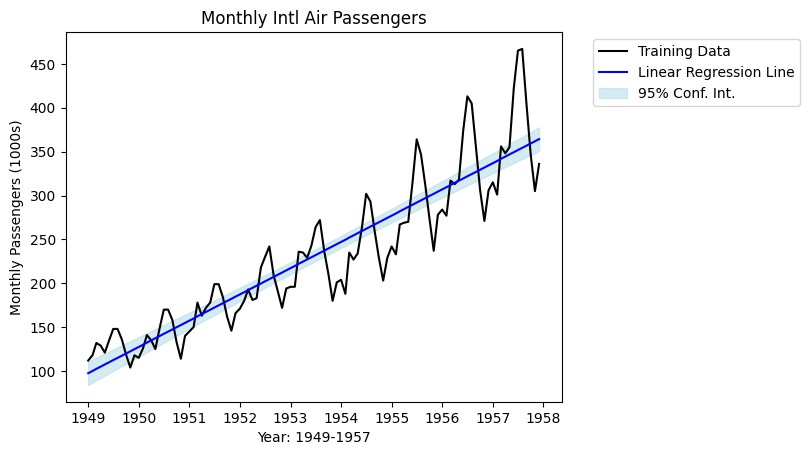

In [14]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## **ARIMA: Begin training the model.**

In [15]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Fri, 17 Jan 2025   AIC                            704.001
Time:                                    00:32:07   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

- The `auto_arima` function suggests `ARIMA(1,1,0)(0,1,0,12)`.    

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [16]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [17]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [19]:
resid = auto_arima_model.resid()

**Plot the standardized residuals.**

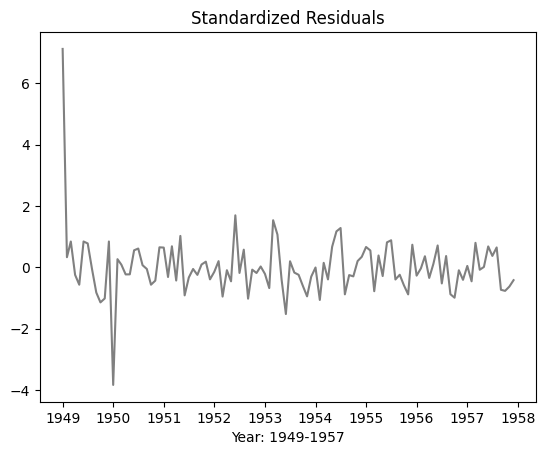

In [20]:
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))